# Data wrangling for Capstone Project 1

## 0. Introduction to the datasets

The raw data files in this project are acquired from UCI Repository at: <br>
1) https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities<br>
2) https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data 

These raw csv files include:<br>
    1) ‘beijing.csv’, ’shanghai.csv’, ‘guangzhou.csv’, ‘chengdu.csv’, ‘shenyang.csv’
These five csv files contain hourly PM2.5 measurements for five major Chinese cities respectively, along with many other meteorological readings collected during the period of 2010-2015. These meteorological readings include dew point (‘DEWP’), temperature(‘TEMP’), humidity(‘HUMI’), pressure(‘PRES’), combined wind direction(‘cbwd’), cumulative wind speed (‘Iws’), hourly precipitation (‘precipitation’) and cumulative precipitation (‘Iprec’). <br>
    2) ‘beijing_2.csv’
This csv file contains similar hourly measurement data for city Beijing alone during the period of 2010-2014, with two unique columns, cumulative hours of snow (‘Is’) and cumulative hours of rain (‘Ir’). 

## 1. Import relevant modules
Let's start by importing all relevant modules and packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Import raw data files
Here, pd.read_csv() is used to import all six raw csv files into pandas as dataframes.<br>
While importing, a new column ‘city’ is added to label the city(source of the csv file) each entry is associated with.<br>
After importing, use pd.concat() to concatenate all six dataframes into one single dataframe named as pm_raw.

In [2]:
#create an empty list named dfs to temperarily store individual dfs for concatenating later
dfs=[]

#import data from six csv files for five cities into pandas
citynames = ['beijing','shanghai','guangzhou','chengdu','shenyang','beijing_2']
for cityname in citynames:
    df = pd.read_csv('datasets/{}.csv'.format(cityname))
    #add a column 'City' to each dataset to store the city information for the corresponding dataset
    df['city'] = cityname
    #append each df to the list dfs
    dfs.append(df)

#concatenate all dfs into a single dataframe named pm_raw
pm_raw=pd.concat(dfs, sort=False)
#reset index after concatenation and discard the original index
pm_raw=pm_raw.reset_index(drop=True)

## 3. Understanding the dataset & Choose data wrangling strategies

Exploratory commands, including df.info(),df.head(),df.tail(),df.describe(),df.columns etc., are executed behind the scene to build a quick understanding of the dataset.<br> 
In addition, because the data come from six separate csv files, boolean index is used to slice and look up the column names imported from each csv file. This reveals the similarities and differences among data from different csv files.

### Understanding the dataset: 

This is a large time series dataset with 306744 rows and 30 columns, as a combination of datetime records and various measurements taken at multiple stations in each city for a total of five cites in China from year 2010 to 2015. Given the large size of this raw dataset, the approach is to divide it into a few subsets according to its characteristics.

### Characteristis of the dataset:

1) Common columns: 
    - datetime related columns: 'year','month','day','hour','season'
    - measurement related columns: 'PM_US Post','DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec'
    - other columns: 'No', 'city'
2) city-specific columns: 
   Besides 'PM_US Post', additional PM2.5 data are available from different stations for each city, and labeled by their station-specific column names. e.g.:
    - beijing: 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan'
    - shanghai: 'PM_Jingan','PM_Xuhui'
    - guangzhou: 'PM_City Station', 'PM_5th Middle School' 
    - chengdu: 'PM_Caotangsi', 'PM_Shahepu'
    - shenyang: 'PM_Taiyuanjie', 'PM_Xiaoheyan' 
    These can be extracted as a subset for comparing the measurement consistency among stations in each city.
3) Measurement-specific columns:
    - 'Is':'Cumulated hours of snow' 
    - 'Ir':'Cumulated hours of rain'
   Besides the dataset for 'beijing', there is another set for 'beijing_2', which contains mostly redundant data as dataset 'beijing', except for two additional columns named 'Is' and 'Ir'. These can be extracted as a subset of city 'beijing_2' for comparing the impact of snow versus rain.
4) Missing data and outliers:
    Many missing data are present in several columns. Also, suspicious large data points are spotted from descriptive satistics, indicating outliers.
    
### Data wrangling strategies:

Based on the above characteristics, the following strategies are chosen:

1) Two additional columns will be added:<br>
    **'date_time': **<br>
    datetime information is stored in separated columns in the raw dataset. For further analysis and plotting purpose, a new DateTime formatted column will be created by combining 'year','month','day','hour' columns<br>
    **'pm_average':** <br>
    There is no reason to choose the PM2.5 data from one station over those from other stations, therefore it's most representative to use the average of all PM2.5 readings(including 'PM_US Post') for each city in most of the analysis and visualization purposes. Therefore, a column containing float values representing the average of pm2.5 readings from multiple stations of the same city will be calculated and added. On the other hand, the station-specific individual PM2.5 readings will be extracted as a separate dataset for comparing the measurement consistency among stations for each city.<br>

2) The raw dataset pm_raw will be separated into three separate subsets for cleaning, analysis and visualization:<br>
    **pm_clean:** <br>
    this is the main dataset containing the measurement data for all five cities, here the average pm2.5 reading for each city is used instead of pm2.5 data from individual stations<br>
    **pm_stations:** <br>
    this is a side dataset containing station-specific individual PM2.5 readings. This dataset serves the purpose of comparing the measurement consistency among stations for each city.<br>
    **pm_sr: **<br>
    this is also a side dataset containing information on cumulated hours of snows and rains for city 'beijing'. This dataset serves the purpose of comparing the impact of snow versus rain on PM2.5 readings.<br>
 
3) Missing values and outliers will be evaluated and addressed within each subset. 

## 4. pm_clean: extraction, data wrangling and export
pm_clean is the main set extracted from the raw dataset. It contains the measurement data for all five cities, here the average pm2.5 reading for each city is used instead of pm2.5 data from individual stations.

### Extract pm_clean from pm_raw

In [3]:
#slice relevent columns from pm_raw and store in the main set pm_clean
pm_clean = pm_raw[['year','month','day','hour','season','DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec','city']]

### Drop irrelevant entries from pm_clean

In [4]:
#drop all data from pm_clean where 'city' is 'beijing_2', these data is intended to be handled in a separate subset pm_sr
pm_clean = pm_clean[pm_clean['city'] != 'beijing_2']
#update index and discard the original
pm_clean.reset_index(drop=True,inplace=True)

### Set uniform format for column names

In [5]:
#set all column names to be lowercase names
pm_clean.columns=pm_clean.columns.str.lower()
print(pm_clean.columns)

Index(['year', 'month', 'day', 'hour', 'season', 'dewp', 'humi', 'pres',
       'temp', 'cbwd', 'iws', 'precipitation', 'iprec', 'city'],
      dtype='object')


### Add a new column 'pm_average' to pm_clean
Here, a new Series 'pm_average' containing float values representing the average pm2.5 readings from multiple stations in the same city is first created, then appended to the main set pm_clean

In [6]:
#store the list of column names, for all relevent pm2.5 columns in pm_raw, in a variable named stations
stations = ['PM_US Post','PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','PM_Jingan','PM_Xuhui','PM_City Station','PM_5th Middle School','PM_Caotangsi','PM_Shahepu','PM_Taiyuanjie','PM_Xiaoheyan']

#calculate the mean across all pm2.5 columns in pm_raw using axis=1
#note: no need to calculate the mean for rows where 'city' is 'beijing_2', these data is intended to be handled in a separate subset pm_sr
#note: during importing, pm readings are autofilled with NaNs (missing station data) for stations not belong to the city in that row, these NaNs from irrelevant stations will not participate in the calculation of the mean using skipna=True
pm_average = pm_raw[pm_raw['city'] != 'beijing_2'].loc[:,stations].mean(axis=1,skipna=True)
#assign a name to the new Series
pm_average.name='pm_average'

#check the length of pm_average before concatenating horizontally
assert len(pm_average) == len(pm_clean)

#append pm_average to pm_clean horizontally
pm_clean = pd.concat([pm_clean,pm_average], axis=1)
print(pm_clean.columns)

Index(['year', 'month', 'day', 'hour', 'season', 'dewp', 'humi', 'pres',
       'temp', 'cbwd', 'iws', 'precipitation', 'iprec', 'city', 'pm_average'],
      dtype='object')


### Deal with missing data in pm_clean:
1) the one missing value in 'season' column is investigated and dropped, becase most other measurement data in this row are also missing<br>
2) missing values in all measurement columns are filled using forward fill and backward fill. To prevent obscuring the trend by extending a value to too many NaNs, only forward fill and backward fill up to one adjacent row.<br>
3) after filling, the rows with missing 'pm_average' data is dropped because pm data is the key focus in this set. For the rest of the missing data in columns 'dewp','humi','pres','temp','cbwd','iws','precipitation','iprec', leave them as they are, because the missing values in one of these columns will not impact the correlation between 'pm_average' and other columns.<br>
4) reset index after completing all the dropping

In [7]:
#1) identify missing values in 'season' column
pm_clean['season'].value_counts(dropna=False)
#look into the row with missing values in 'season' column
#note: all the measurement data is missing in this row except for the 'pm_average' column
print(pm_clean[pm_clean['season'].isna()])
#drop this particular row with too many NaNs
pm_clean.dropna(subset=['season'],inplace=True)
#confirm no missing data in 'season' column
assert pm_clean['season'].notnull().all()

#2) deal with missing data in all other columns, i.e.: 'pm_average','dewp','humi','pres','temp','cbwd','iws','precipitation','iprec'
#first use method='ffill' and limit=1 to fill in missing values down the columns for up to one row only
pm_clean.fillna(method='ffill',limit=1,inplace=True)
#then use method='bfill' and limit=1 to fill in missing values up the columns for up to one row only
pm_clean.fillna(method='bfill',limit=1,inplace=True)

#3) for the rest of the missing data: drop rows with missing 'pm_average' data
pm_clean = pm_clean[pm_clean['pm_average'].notna()]

#4) update index after dropping
pm_clean.reset_index(drop=True,inplace=True)
print(pm_clean.info())

        year  month  day  hour  season  dewp  humi  pres  temp cbwd  iws  \
157751  2015     12   31    23     NaN   NaN   NaN   NaN   NaN  NaN  NaN   

        precipitation  iprec       city  pm_average  
157751            NaN    NaN  guangzhou        63.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176267 entries, 0 to 176266
Data columns (total 15 columns):
year             176267 non-null int64
month            176267 non-null int64
day              176267 non-null int64
hour             176267 non-null int64
season           176267 non-null float64
dewp             175801 non-null float64
humi             175474 non-null float64
pres             175460 non-null float64
temp             175801 non-null float64
cbwd             175801 non-null object
iws              175793 non-null float64
precipitation    172181 non-null float64
iprec            172181 non-null float64
city             176267 non-null object
pm_average       176267 non-null float64
dtypes: float64(9), int

### Convert the data types in 'season' column:
The above results also reveal that the 'season' column has a data type of float64, even though it only has four unique values of 1.0, 2.0, 3.0 and 4.0. Converting dtype in 'season' from float to int will help to save up on memory.

In [8]:
#convert the data type of 'season' column from float to int
pm_clean['season'] = pm_clean['season'].astype(int)

### Add DateTime format column 'date_time' to pm_clean
A new column named 'date_time' is created to store the DateTime format data from time-related columns:'year','month','day','hour'. <br>
Here, we keep both individual columns for 'year','month','day','hour','season' and the combined 'date_time' column in pm_clean. The former is great for use in groupbys, whereas the later is great for plotting time series data.

In [9]:
#initialize an empty column named 'date_time'
pm_clean['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_clean.columns[0:4]):
    #convert to string data type
    to_str = pm_clean[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_clean['date_time'] += to_str
    
#doublecheck values in 'date_time' column before converting to DateTime format
print(pm_clean['date_time'].head(3))
#convert 'date_time' column from string object to DateTime object
pm_clean['date_time'] = pd.to_datetime(pm_clean['date_time'], format='%Y%m%d%H')

#doublecheck the values in 'date_time' column after converting
print(pm_clean['date_time'].head(3))

0    2010010122
1    2010010123
2    2010010200
Name: date_time, dtype: object
0   2010-01-01 22:00:00
1   2010-01-01 23:00:00
2   2010-01-02 00:00:00
Name: date_time, dtype: datetime64[ns]


### Identify outliers
Here, the summary statistics are shown for all the numerical columns. A few unusual numbers are noticed:<br> 
1) max values in 'iws', 'precipitation', 'iprec' and 'pm_average' look unusually large;<br>
2) min values in 'dewp' and 'humi' look unreasonably small/negative; <br>
these could be the potential outliers to further investigate in. 

In [10]:
# look at the summary statistics for all numerical columns to spot outliers
print(pm_clean.describe())

                year          month            day           hour  \
count  176267.000000  176267.000000  176267.000000  176267.000000   
mean     2013.344137       6.664310      15.785780      11.505829   
std         1.380304       3.443411       8.807779       6.922122   
min      2010.000000       1.000000       1.000000       0.000000   
25%      2012.000000       4.000000       8.000000       6.000000   
50%      2013.000000       7.000000      16.000000      12.000000   
75%      2014.000000      10.000000      23.000000      18.000000   
max      2015.000000      12.000000      31.000000      23.000000   

              season           dewp           humi           pres  \
count  176267.000000  175801.000000  175474.000000  175460.000000   
mean        2.500616       8.363214      66.001884    1013.671979   
std         1.106692      49.446476      53.211367      10.080623   
min         1.000000   -9999.000000   -9999.000000     975.000000   
25%         2.000000       0.0000

### Exam the 'iws' column for outliers
Here, histogram and boxplot are used to exam the numeric values in 'iws' column. In addition, the entries near the largest 'iws' value are printed out. The plots and nearby entries reveal that the high values near row 55847 are not necessarily outliers. No action is necessary.  

55847
55845    679.0
55846    685.0
55847    691.0
55848      5.0
55849      6.0
55850     12.0
Name: iws, dtype: float64


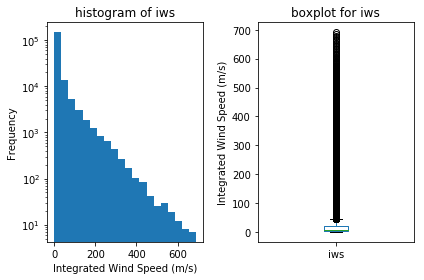

In [35]:
#plot histogram of the 'iws' column
plt.subplot(1,2,1)
pm_clean['iws'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('Integrated Wind Speed (m/s)')
plt.title('histogram of iws')

#plot the boxplot of the 'iws' column
plt.subplot(1,2,2)
pm_clean['iws'].plot(kind='box')
plt.ylabel('Integrated Wind Speed (m/s)')
plt.title('boxplot for iws')
plt.tight_layout()

#print the entries near the largest 'iws' value
print(pm_clean['iws'].idxmax())
print(pm_clean.loc[55845:55850,'iws'])

### Exam the 'precipitation' column for outliers
Here, histogram and boxplot are used to exam the numeric values in the 'precipitation' column. In addition, the entries near the largest 'precipitation' value are printed out. The plots and nearby entries reveal that the max value at row 49612 is definitely an outlier. Therefore, its value is replaced by the value in its previous entry.

49612
49610         0.0
49611         0.0
49612    999990.0
49613         0.0
49614         0.0
49615         0.0
Name: precipitation, dtype: float64


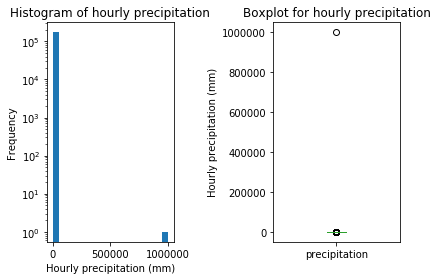

In [12]:
#plot histogram of the 'precipitation' column
plt.subplot(1,2,1)
pm_clean['precipitation'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('Hourly precipitation (mm)')
plt.title('Histogram of hourly precipitation')

#plot the boxplot of the 'precipitation' column
plt.subplot(1,2,2)
pm_clean['precipitation'].plot(kind='box')
plt.ylabel('Hourly precipitation (mm)')
plt.title('Boxplot for hourly precipitation')
plt.tight_layout()

#print the entries near the largest 'precipitation' value
print(pm_clean['precipitation'].idxmax())
print(pm_clean.loc[49610:49615,'precipitation'])

#remove the outlier by replacing its value with its previous entry 0.0
pm_clean.loc[49612,'precipitation']= 0.0

### Exam the 'iprec' column for outliers
Here, histogram and boxplot are used to exam the numeric values in the 'iprec' column. In addition, the entries near the largest 'iprec' value are printed out. The plots and nearby entries reveal that the max value at row 49612 is definitely an outlier. Therefore, its value is replaced by the value in its previous entry.

49612
49610         0.0
49611         0.0
49612    999990.0
49613         0.0
49614         0.0
49615         0.0
Name: iprec, dtype: float64


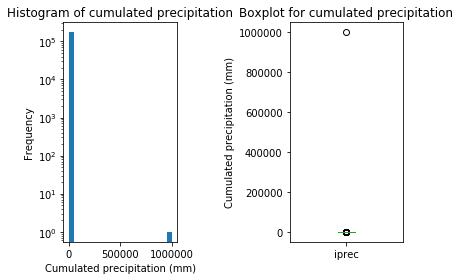

In [13]:
#plot histogram of the 'iprec' column
plt.subplot(1,2,1)
pm_clean['iprec'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('Cumulated precipitation (mm)')
plt.title('Histogram of cumulated precipitation')

#plot the boxplot of the 'iprec' column
plt.subplot(1,2,2)
pm_clean['iprec'].plot(kind='box')
plt.ylabel('Cumulated precipitation (mm)')
plt.title('Boxplot for cumulated precipitation')
plt.tight_layout()

#print the entries near the largest 'iprec' value
print(pm_clean['iprec'].idxmax())
print(pm_clean.loc[49610:49615,'iprec'])

#remove the outlier by replacing its value with its previous entry 0.0
pm_clean.loc[49612,'iprec']= 0.0

### Exam the 'pm_average' column for outliers
Here, histogram and boxplot are used to exam the numeric values in the 'pm_average' column. In addition, the entries near the largest 'pm_average' value are printed out. The plots and nearby entries reveal that the high values near row 174982 are not likely to be outliers.

174984
174982     967.333333
174983    1034.000000
174984    1134.666667
174985    1129.666667
174986    1053.000000
174987     992.000000
174988     955.000000
Name: pm_average, dtype: float64


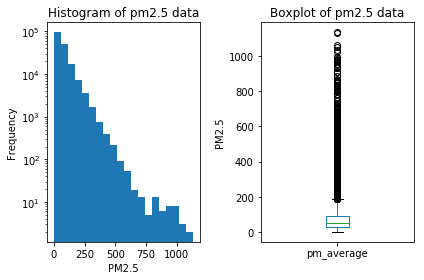

In [14]:
#plot histogram of the 'pm_average' column
plt.subplot(1,2,1)
pm_clean['pm_average'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('PM2.5')
plt.title('Histogram of pm2.5 data')

#plot the boxplot of the 'pm_average' column
plt.subplot(1,2,2)
pm_clean['pm_average'].plot(kind='box')
plt.ylabel('PM2.5')
plt.title('Boxplot of pm2.5 data')
plt.tight_layout()

#print the entries near the largest 'pm2.5' value
print(pm_clean['pm_average'].idxmax())
print(pm_clean.loc[174982:174988,'pm_average'])

### Exam the 'dewp' column for outliers
Here, histogram and boxplot are used to exam the numeric values in the 'dewp' column. In addition, the entries near the lowest 'dewp' value are printed out. The plots and nearby entries reveal that the min values at row 101487:101491 are definitely outliers. Therefore, their values are replaced by the nearest valid entry.

101487
101485      13.2
101486      13.0
101487   -9999.0
101488   -9999.0
101489   -9999.0
101490   -9999.0
101491      13.4
101492      11.4
101493      12.1
Name: dewp, dtype: float64


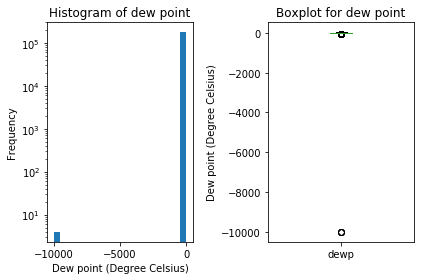

In [15]:
#plot histogram of the 'dewp' column
plt.subplot(1,2,1)
pm_clean['dewp'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('Dew point (Degree Celsius)')
plt.title('Histogram of dew point')

#plot the boxplot of the 'dewp' column
plt.subplot(1,2,2)
pm_clean['dewp'].plot(kind='box')
plt.ylabel('Dew point (Degree Celsius)')
plt.title('Boxplot for dew point')
plt.tight_layout()

#print the entries near the lowest 'dewp' value
print(pm_clean['dewp'].idxmin())
print(pm_clean.loc[101485:101493,'dewp'])

#remove the outliers by replacing their values with the nearest valid entry 13.2
pm_clean.loc[101487:101491,'dewp'] = 13.2

### Exam the 'humi' column for outliers
Here, histogram and boxplot are used to exam the numeric values in the 'humi' column. In addition, the entries near the lowest 'humi' value are printed out. These reveal that the negative values at row 101487:101491 are definitely outliers. Therefore, their values are replaced by the nearest valid entry.

101487
101485     100.0
101486     100.0
101487   -9999.0
101488   -9999.0
101489   -9999.0
101490   -9999.0
101491     100.0
101492      89.0
101493      95.0
Name: humi, dtype: float64


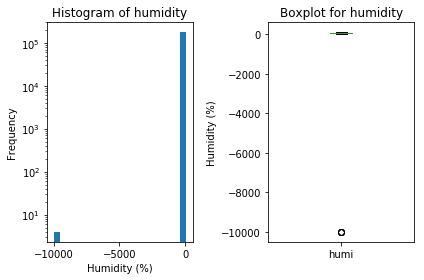

In [16]:
#plot histogram of the 'humi' column
plt.subplot(1,2,1)
pm_clean['humi'].plot(kind='hist',bins=20, logy=True)
plt.xlabel('Humidity (%)')
plt.title('Histogram of humidity')

#plot the boxplot of the 'humi' column
plt.subplot(1,2,2)
pm_clean['humi'].plot(kind='box')
plt.ylabel('Humidity (%)')
plt.title('Boxplot for humidity')
plt.tight_layout()

#print the entries near the lowest 'humi' value
print(pm_clean['humi'].idxmin())
print(pm_clean.loc[101485:101493,'humi'])

#remove the outliers by replacing their values with the nearest valid entry 100.0
pm_clean.loc[101487:101491,'humi'] = 100.0

### Exam the valid entries in the non-numerical column 'cbwd'
The values in the non-numerical column 'cbwd'(combined wind direction) are examed. Both lowercase values and uppercases values are present. Values need to be updated to all uppercases. 

In [17]:
print(pm_clean['cbwd'].value_counts(dropna=False))
#update all letters to uppercases for all valid entries in this column
pm_clean['cbwd']=pm_clean['cbwd'].str.upper()

NW     44124
SE     41244
NE     38627
cv     29153
SW     22653
NaN      466
Name: cbwd, dtype: int64


### Save the cleaned dataset pm_clean to CSV file
Now the main set pm_clean is cleaned up and ready for analysis. Export it to file for documentation and future analysis.

In [18]:
#save pm_clean to csv file
pm_clean.to_csv(path_or_buf='pm_clean.csv')

## 5. pm_stations: extraction, data wrangling and export
pm_stations is a side dataset extracted from the raw dataset pm_raw.<br>
It contains s thetation-specific individual PM2.5 readings, and serves the purpose of comparing the measurement consistency among stations for each city.

### Extract pm_stations from pm_raw

In [19]:
#slice relevent columns from pm_raw and store in the dataset pm_stations
pm_stations = pm_raw[['year','month','day','hour','season','city','PM_US Post','PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','PM_Jingan','PM_Xuhui','PM_City Station','PM_5th Middle School','PM_Caotangsi','PM_Shahepu','PM_Taiyuanjie','PM_Xiaoheyan']]

### drop irrelevant entries from pm_stations

In [20]:
#drop all data from pm_stations where 'city' is 'beijing_2', these data is intended to be handled in a separate subset named pm_sr
pm_stations = pm_stations[pm_stations['city'] != 'beijing_2']
#update index and discard the original
pm_stations.reset_index(drop=True,inplace=True)

### Set uniform format for column names

In [21]:
#update all column names to be lowercase names
pm_stations.columns=pm_stations.columns.str.lower()
print(pm_stations.columns)

Index(['year', 'month', 'day', 'hour', 'season', 'city', 'pm_us post',
       'pm_dongsi', 'pm_dongsihuan', 'pm_nongzhanguan', 'pm_jingan',
       'pm_xuhui', 'pm_city station', 'pm_5th middle school', 'pm_caotangsi',
       'pm_shahepu', 'pm_taiyuanjie', 'pm_xiaoheyan'],
      dtype='object')


### deal with missing data in columns with names featuring 'pm_'
These columns store the raw pm2.5 data collected at individual stations. <br>
Each station is associated with a particular city. For the cities the station doesn't belong to, their values will be labeled as NaN. Therefore, it's expect to have many NaNs in these columns, since each row is for only one out of the five cities. <br>
Since we will only compare the station data originated from the same city, it's ok to leave the rest of the missing values as they are. <br>
But for rows where all station data are missing (values in 'pm_*' columns are all labeled as NaNs), these rows are useless and need to be remov

In [22]:
#drop rows where data in pm columns are all missing
stations=['pm_us post','pm_dongsi','pm_dongsihuan','pm_nongzhanguan','pm_jingan','pm_xuhui','pm_city station','pm_5th middle school','pm_caotangsi','pm_shahepu','pm_taiyuanjie','pm_xiaoheyan']
pm_stations.dropna(how='all',inplace=True, subset=stations)
#reset the index by dropping the original
pm_stations.reset_index(drop=True,inplace=True)

### Deal with missing data in the 'season' column: 
locate and fill in the one missing value in the 'season' column with its previous entry, because they share the same 'season' values as they are entries for different hours on the same day in the same season. 

In [23]:
print(pm_stations[pm_stations['season'].isna()])
#look at its nearby entry, and replace the missing value with its nearby entry
pm_stations.loc[118857,'season'] = pm_stations.loc[118856,'season']
#confirm no presence of missing values in 'season'
assert pm_stations['season'].notnull().all()

        year  month  day  hour  season       city  pm_us post  pm_dongsi  \
118857  2015     12   31    23     NaN  guangzhou        63.0        NaN   

        pm_dongsihuan  pm_nongzhanguan  pm_jingan  pm_xuhui  pm_city station  \
118857            NaN              NaN        NaN       NaN             63.0   

        pm_5th middle school  pm_caotangsi  pm_shahepu  pm_taiyuanjie  \
118857                   NaN           NaN         NaN            NaN   

        pm_xiaoheyan  
118857           NaN  


### Update the data type in the 'season' column from float to int

In [24]:
#convert the data type of 'season' column from float to int to save on memory
pm_stations['season'] = pm_stations['season'].astype(int)

### Add DateTime format column 'date_time' to pm_stations
A new column named 'date_time' is created to store the DateTime format data from the time-related columns:'year','month','day','hour'.<br>
Set the newly created 'date_time' column as DateTime Index for future analysis purposes.

In [25]:
#initialize an empty column named 'date_time'
pm_stations['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_stations.columns[0:4]):
    #convert to string data type
    to_str = pm_stations[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_stations['date_time'] += to_str
    
#doublecheck values in 'date_time' column before converting to DateTime format
print(pm_stations['date_time'].head(3))
#convert 'date_time' column from string object to DateTime object
pm_stations['date_time'] = pd.to_datetime(pm_stations['date_time'], format='%Y%m%d%H')

#set the 'date_time' column as the DateTime index
pm_stations.set_index('date_time',inplace=True)
print(pm_stations.index)

0    2010010123
1    2010010200
2    2010010201
Name: date_time, dtype: object
DatetimeIndex(['2010-01-01 23:00:00', '2010-01-02 00:00:00',
               '2010-01-02 01:00:00', '2010-01-02 02:00:00',
               '2010-01-02 03:00:00', '2010-01-02 04:00:00',
               '2010-01-02 05:00:00', '2010-01-02 06:00:00',
               '2010-01-02 07:00:00', '2010-01-02 08:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=175245, freq=None)


### Save the cleaned dataset pm_stations to CSV file
Now the dataset pm_stations is cleaned up and ready for analysis. Export it to file for documentation and future analysis.

In [26]:
#save pm_stations to file
pm_stations.to_csv(path_or_buf='pm_stations.csv')

## 6. pm_sr: extract, data wrangling and export
pm_sr is a side dataset extracted from the raw dataset pm_raw. <br>
It contains information on cumulated hours of snows and rains (column 'Ir' and 'Is') for city 'beijing_2', and serves the purpose of comparing the impact of snow versus rain on PM2.5 readings.

### Extract pm_sr from pm_raw

In [27]:
#slice relevent columns from pm_raw and store in the dataset pm_sr
pm_sr = pm_raw[['year','month','day','hour','city','DEWP','PRES','TEMP','cbwd','Iws','pm2.5','Is','Ir']]

### Drop irrelevant entries from pm_sr
keep only entries/rows where 'city' is 'beijing_2' and drop all other rows, because only these rows associated with 'beijing_2' have measurement data in columns 'Ir' and 'Is'.

In [28]:
#keep only entries where 'city' is 'beijing_2' 
pm_sr = pm_sr[pm_sr['city'] == 'beijing_2']
#update index by dropping the original
pm_sr.reset_index(drop=True,inplace=True)

### Set uniform format for column names

In [29]:
#set all column names to be lowercases
pm_sr.columns=pm_sr.columns.str.lower()
print(pm_sr.columns)

Index(['year', 'month', 'day', 'hour', 'city', 'dewp', 'pres', 'temp', 'cbwd',
       'iws', 'pm2.5', 'is', 'ir'],
      dtype='object')


### Deal with missing data
pm_sr.info() reveals that only the 'pm2.5' column in this dataset contains some missing data. Given the main purpose of this subset pm_sr is to compare the impact of snow('Is') vs rain('Ir') on PM2.5 readings('pm2.5'), rows with missing pm2.5 data are not useful and can be removed.

In [30]:
#drop rows with missing 'pm2.5' values as these rows are not useful
pm_sr.dropna(subset=['pm2.5'],inplace=True)
#update index by dropping the original
pm_sr.reset_index(drop=True,inplace=True)

### Exam potential outliers in numerical columns
Use pm_sr.describe() to look at the summary statistics for all numerical columns. <br>
The max values in columns 'iws','pm2.5', 'is' and 'ir' look much larger than the mean and 75% quantile, and could be potential outliers. <br>
Plotting histograms reveal that none of these max values are obvious outliers, therefore no action is needed.

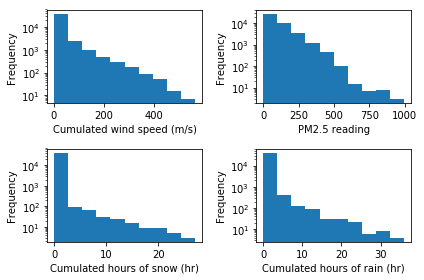

In [31]:
#plot the value distribution in columns 'Iws','pm2.5','Is' and 'Ir'
plt.subplot(2,2,1)
pm_sr['iws'].plot(kind='hist',logy=True)
plt.xlabel('Cumulated wind speed (m/s)')
plt.subplot(2,2,2)
pm_sr['pm2.5'].plot(kind='hist',logy=True)
plt.xlabel('PM2.5 reading')
plt.subplot(2,2,3)
pm_sr['is'].plot(kind='hist',logy=True)
plt.xlabel('Cumulated hours of snow (hr)')
plt.subplot(2,2,4)
pm_sr['ir'].plot(kind='hist',logy=True)
plt.xlabel('Cumulated hours of rain (hr)')
plt.tight_layout()

### Exam the valid entries in the non-numerical column 'cbwd'
The values in the non-numerical column 'cbwd'(combined wind direction) are examed. Both lowercase values and uppercases values are present. Update values to all uppercases.

In [32]:
print(pm_sr['cbwd'].value_counts())
#update all values in this column to uppercases
pm_sr['cbwd']=pm_sr['cbwd'].str.upper()

SE    14573
NW    13484
cv     8944
NE     4756
Name: cbwd, dtype: int64


### Add DateTime format column 'date_time' to pm_sr
A new column named 'date_time' is created to store the DateTime format data from the time-related columns:'year','month','day','hour'.

In [33]:
#initialize an empty column named 'date_time'
pm_sr['date_time']=''
#iterate through 'year','month','day','hour' columns, convert int/float to string type, append to 'date_time' column
for idx, col in enumerate(pm_sr.columns[0:4]):
    #convert to string data type
    to_str = pm_sr[col].astype(str)
    #for 'month','day' and 'hour', update all string lengths to 2 by filling in 0 from the left  
    to_str = pd.Series([('0'+entry) if len(entry) < 2 else entry for entry in to_str])   
    #use string concatenation to append each time string to the 'date_time' column
    pm_sr['date_time'] += to_str
    
#convert 'date_time' column from string object to DateTime object
pm_sr['date_time'] = pd.to_datetime(pm_sr['date_time'], format='%Y%m%d%H')

### Save the cleaned dataset pm_sr to CSV file
Now the dataset pm_sr is cleaned up and ready for analysis. Export it to file for documentation and future analysis.

In [34]:
#save pm_sr to file
pm_sr.to_csv(path_or_buf='pm_sr.csv')